Importing necessary libraries and sets up the environment

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings for Jupyter Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Setting display options for Pandas
pd.set_option("display.max_columns", None)


In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

prompts=pd.read_csv('train_prompts.csv')

In [3]:
#checking the shape of the dataset
train.shape
test.shape
prompts.shape

#Checking the names of the columns
train.columns
test.columns
prompts.columns

(212, 4)

(188, 3)

(2, 4)

Index(['id', 'prompt_id', 'text', 'generated'], dtype='object')

Index(['id', 'prompt_id', 'text'], dtype='object')

Index(['prompt_id', 'prompt_name', 'instructions', 'source_text'], dtype='object')

In [4]:
# Merging the dataset
train=pd.merge(train,prompts,on='prompt_id',how='left')

In [5]:
#Checking the first 5 rows to see how data look's like
train.head()
test.head()

,id,prompt_id,text,generated,prompt_name,instructions,source_text
0,e663b2f5,0,The ideal career choice is one that aligns pas...,0,The Ideal Career Choice,\nWrite an explanatory essay to inform fellow ...,#How to Choose a Career: 7 Ways to Narrow Your...
1,dc1bd601,0,The ideal career choice is one that aligns wit...,0,The Ideal Career Choice,\nWrite an explanatory essay to inform fellow ...,#How to Choose a Career: 7 Ways to Narrow Your...
2,3f28d007,0,The ideal career choice is one that aligns wit...,0,The Ideal Career Choice,\nWrite an explanatory essay to inform fellow ...,#How to Choose a Career: 7 Ways to Narrow Your...
3,46232258,0,The ideal career choice is one that aligns wit...,0,The Ideal Career Choice,\nWrite an explanatory essay to inform fellow ...,#How to Choose a Career: 7 Ways to Narrow Your...
4,f9fff5c6,0,The ideal career choice is one that aligns wit...,0,The Ideal Career Choice,\nWrite an explanatory essay to inform fellow ...,#How to Choose a Career: 7 Ways to Narrow Your...


,id,prompt_id,text
0,63cf09af,0,The ideal career choice is one that aligns wit...
1,908e398d,0,#Pursuing Passion in Professions \n The ideal ...
2,5e281241,0,The ideal career choice is one that aligns wit...
3,5f57d123,0,#Embracing Diversity in Career Choices \n Dive...
4,5bef5435,0,The ideal career choice is one that aligns wit...


In [6]:
#cheking for the null values
train.isnull().sum()
test.isnull().sum()


id              0
prompt_id       0
text            0
generated       0
prompt_name     0
instructions    0
source_text     0
dtype: int64

id           0
prompt_id    0
text         0
dtype: int64

In [7]:
#checking the Target variable 0 is generated by LLM and 1 is written by a student
train['generated'].value_counts()

1    184
0     28
Name: generated, dtype: int64

<AxesSubplot:xlabel='generated', ylabel='count'>

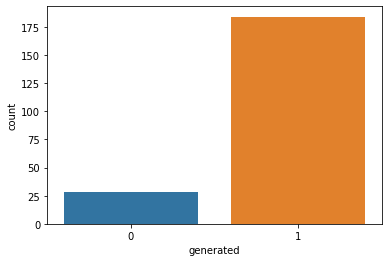

In [8]:
sns.countplot(train['generated'])

As we can see that this is a imbalanced dataset so we can use either under sampling or over sampling .In Over-Samplingwe can use 
SMOTE(Synthetic Minority Over Sampling Technique) to create synthetic samples for minority class to balanced the classdistribution.
We can also use ensemble methods such as Random Forest or AdaBoost because these algorithm can handle imbalanced dataset well by 
giving more weight to minority class instances.

In [9]:
def calculate_word_count(text):
    return len(text.split())

def calculate_avg_word_length(text):
    words = text.split()
    return np.mean([len(word) for word in words])

# Additional Feature Engineering
train['word_count'] = train['text'].apply(calculate_word_count)
train['avg_word_length'] = train['text'].apply(calculate_avg_word_length)

In [10]:
# Data Preprocessing with adjusted TF-IDF vectorization
max_features = 5000
stop_words = 'english'
ngram_range = (1, 2)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=max_features, stop_words=stop_words, ngram_range=ngram_range)

# Fit and Transform the 'text' column
X_tfidf = tfidf_vectorizer.fit_transform(train['text'])

# Convert the result to an array
X_tfidf_array = X_tfidf.toarray()

In [12]:
# Additional features for TF-IDF vectorization
additional_features = train[['word_count', 'avg_word_length']].values

# Combine TF-IDF and additional features horizontally
X_combined = np.hstack([X_tfidf_array, additional_features])


In [13]:
# Split Data
X_train, X_val, y_train, y_val = train_test_split(X_combined, train['generated'], test_size=0.2, random_state=42)

# Oversample class 0
oversampler = SMOTE(sampling_strategy='auto', random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Hyperparameter Tuning
model_class_0 = SVC(random_state=42, C=1.0, kernel='linear', class_weight='balanced')  # Support Vector Machines

# Feature Scaling for SVM on Training Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)
X_val_scaled = scaler.transform(X_val)

# Fit the SVM model for class 0
model_class_0.fit(X_train_scaled, y_train_oversampled)

# Make Predictions
y_pred = model_class_0.predict(X_val_scaled)

# Evaluate the Model
print("\nModel - SVM for Class 0:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))


SVC(class_weight='balanced', kernel='linear', random_state=42)


Model - SVM for Class 0:
Accuracy: 0.9767441860465116

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.97      1.00      0.99        37

    accuracy                           0.98        43
   macro avg       0.99      0.92      0.95        43
weighted avg       0.98      0.98      0.98        43


Confusion Matrix:
[[ 5  1]
 [ 0 37]]


In [14]:
test['word_count'] = test['text'].apply(calculate_word_count)
test['avg_word_length'] = test['text'].apply(calculate_avg_word_length)

# Data Preprocessing for Test Data
X_tfidf_test = tfidf_vectorizer.transform(test['text']).toarray()
X_additional_test = test[['word_count', 'avg_word_length']].values
X_combined_test = np.hstack([X_tfidf_test, X_additional_test])

# Feature Scaling for SVM on Test Data
X_combined_test_scaled = scaler.transform(X_combined_test)

# Make Predictions on Test Data
y_pred_test = model_class_0.predict(X_combined_test_scaled)

# Combine Predictions for Test Set
y_pred_combined_test = test.copy()
y_pred_combined_test['generated'] = y_pred_test

# Display the updated Test Set with Predictions
print("\nTest Set with Predictions:")
print(y_pred_combined_test[['id', 'prompt_id', 'generated']])

# Save Predictions to Submission File
submission_file_path = os.path.join('D:\\abhi\\Participants_Dataset_LLM_Hackathon', 'submission_2.csv')
y_pred_combined_test[['id', 'prompt_id', 'generated']].to_csv(submission_file_path, index=False)


Test Set with Predictions:
           id  prompt_id  generated
0    63cf09af          0          0
1    908e398d          0          0
2    5e281241          0          0
3    5f57d123          0          0
4    5bef5435          0          0
..        ...        ...        ...
183  8312d6fa          1          1
184  a46dc136          1          1
185  75bb5544          1          1
186  2fa6f12a          1          1
187  463be5e6          1          1

[188 rows x 3 columns]
